# L0 Regularization Examples

This notebook demonstrates L0 regularization with practical examples, including reproductions of key results from {cite}`louizos2018learning`.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Import L0 modules
from l0.layers import L0Linear, L0Conv2d, SparseMLP
from l0.gates import FeatureGate, SampleGate
from l0.penalties import (
    compute_l0_penalty,
    get_sparsity_stats,
    TemperatureScheduler,
    update_temperatures
)

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## 1. Basic L0 Linear Layer

Let's start with a simple example showing how L0 regularization learns sparsity.

In [2]:
# Create synthetic data
n_samples = 1000
n_features = 100
n_informative = 10  # Only 10 features are actually useful

# Generate data where only first 10 features matter
X = torch.randn(n_samples, n_features)
true_weights = torch.zeros(n_features)
true_weights[:n_informative] = torch.randn(n_informative) * 2
y = X @ true_weights + torch.randn(n_samples) * 0.1

# Create train/test split
train_X, test_X = X[:800], X[800:]
train_y, test_y = y[:800], y[800:]

print(f"Data shape: {X.shape}")
print(f"True informative features: {n_informative}/{n_features}")

Data shape: torch.Size([1000, 100])
True informative features: 10/100


In [3]:
# Create L0 regularized linear model
class L0LinearRegression(nn.Module):
    def __init__(self, n_features, init_sparsity=0.9):
        super().__init__()
        self.l0_linear = L0Linear(
            n_features, 1,
            bias=False,
            init_sparsity=init_sparsity,
            temperature=0.5
        )
    
    def forward(self, x):
        return self.l0_linear(x).squeeze()
    
    def get_l0_loss(self):
        return self.l0_linear.get_l0_penalty()
    
    def get_sparsity(self):
        return self.l0_linear.get_sparsity()

model = L0LinearRegression(n_features, init_sparsity=0.5).to(device)
print(f"Initial sparsity: {model.get_sparsity():.2%}")

Initial sparsity: 23.17%


In [4]:
# Training with L0 regularization
optimizer = optim.Adam(model.parameters(), lr=0.01)
l0_lambda = 0.01  # L0 regularization strength

losses = []
sparsities = []

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    pred = model(train_X.to(device))
    mse_loss = F.mse_loss(pred, train_y.to(device))
    l0_loss = model.get_l0_loss()
    total_loss = mse_loss + l0_lambda * l0_loss
    
    # Backward pass
    total_loss.backward()
    optimizer.step()
    
    losses.append(total_loss.item())
    sparsities.append(model.get_sparsity())
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}: Loss={total_loss:.4f}, Sparsity={sparsities[-1]:.2%}")

Epoch 20: Loss=62.6100, Sparsity=24.81%
Epoch 40: Loss=77.1256, Sparsity=26.15%
Epoch 60: Loss=48.4199, Sparsity=27.17%
Epoch 80: Loss=49.7206, Sparsity=28.02%
Epoch 100: Loss=35.3433, Sparsity=28.71%


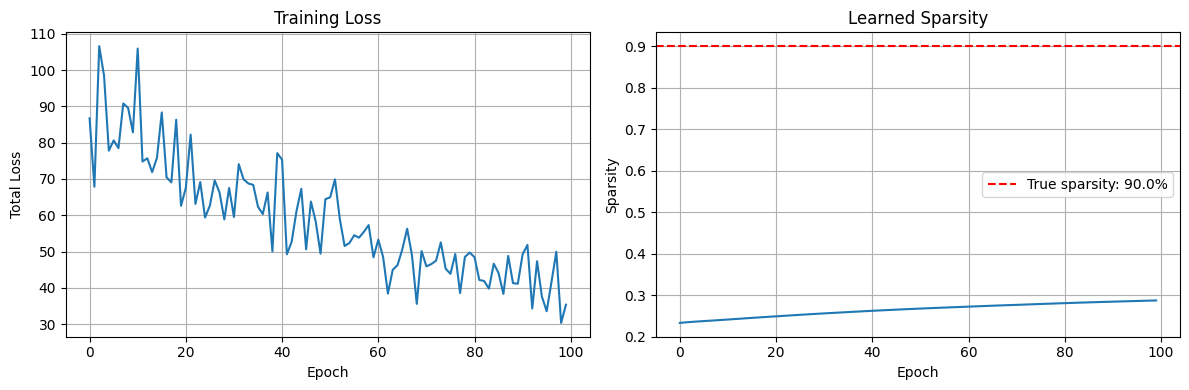

Final sparsity: 28.71%
True sparsity: 90.0%


In [5]:
# Visualize training
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(losses)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Total Loss')
ax1.set_title('Training Loss')
ax1.grid(True)

ax2.plot(sparsities)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Sparsity')
ax2.set_title('Learned Sparsity')
ax2.grid(True)
ax2.axhline(y=(n_features-n_informative)/n_features, color='r', linestyle='--', 
            label=f'True sparsity: {(n_features-n_informative)/n_features:.1%}')
ax2.legend()

plt.tight_layout()
plt.show()

print(f"Final sparsity: {model.get_sparsity():.2%}")
print(f"True sparsity: {(n_features-n_informative)/n_features:.1%}")

Active features: 20/100
Correctly identified informative features: 5/10
False positives: 15/90


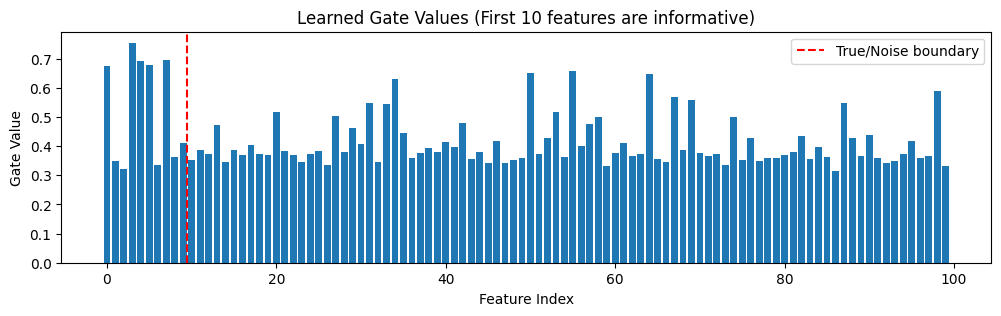

In [6]:
# Analyze which features were selected
model.eval()
with torch.no_grad():
    gates = model.l0_linear.weight_gates()
    active_features = (gates.squeeze() > 0.5).cpu().numpy()
    
print(f"Active features: {active_features.sum()}/{n_features}")
print(f"Correctly identified informative features: {active_features[:n_informative].sum()}/{n_informative}")
print(f"False positives: {active_features[n_informative:].sum()}/{n_features-n_informative}")

# Visualize gate values
plt.figure(figsize=(12, 3))
plt.bar(range(n_features), gates.squeeze().cpu().numpy())
plt.axvline(x=n_informative-0.5, color='r', linestyle='--', label='True/Noise boundary')
plt.xlabel('Feature Index')
plt.ylabel('Gate Value')
plt.title('Learned Gate Values (First 10 features are informative)')
plt.legend()
plt.show()

## 2. LeNet-5 on MNIST with L0

Reproducing a simplified version of the LeNet experiments from the paper.

In [7]:
# Simple MNIST data (using random data for demo - replace with real MNIST)
# In practice, use torchvision.datasets.MNIST
mnist_train_X = torch.randn(1000, 1, 28, 28)
mnist_train_y = torch.randint(0, 10, (1000,))
mnist_test_X = torch.randn(200, 1, 28, 28)
mnist_test_y = torch.randint(0, 10, (200,))

train_dataset = TensorDataset(mnist_train_X, mnist_train_y)
test_dataset = TensorDataset(mnist_test_X, mnist_test_y)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [8]:
class L0LeNet5(nn.Module):
    """LeNet-5 with L0 regularization on conv and fc layers."""
    
    def __init__(self, init_sparsity=0.5, temperature=0.5):
        super().__init__()
        # Conv layers with L0
        self.conv1 = L0Conv2d(1, 6, 5, init_sparsity=init_sparsity, temperature=temperature)
        self.conv2 = L0Conv2d(6, 16, 5, init_sparsity=init_sparsity, temperature=temperature)
        
        # FC layers with L0
        self.fc1 = L0Linear(16 * 4 * 4, 120, init_sparsity=init_sparsity, temperature=temperature)
        self.fc2 = L0Linear(120, 84, init_sparsity=init_sparsity, temperature=temperature)
        self.fc3 = L0Linear(84, 10, init_sparsity=init_sparsity, temperature=temperature)
        
        self.pool = nn.MaxPool2d(2, 2)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def get_l0_loss(self):
        l0_loss = 0
        for module in self.modules():
            if hasattr(module, 'get_l0_penalty'):
                l0_loss = l0_loss + module.get_l0_penalty()
        return l0_loss
    
    def get_layer_sparsities(self):
        sparsities = {}
        for name, module in self.named_modules():
            if hasattr(module, 'get_sparsity'):
                sparsities[name] = module.get_sparsity()
        return sparsities

lenet = L0LeNet5(init_sparsity=0.1, temperature=0.5).to(device)
print("Initial layer sparsities:")
for name, sparsity in lenet.get_layer_sparsities().items():
    print(f"  {name}: {sparsity:.2%}")

Initial layer sparsities:
  conv1: 3.24%
  conv1.weight_gates: 3.24%
  conv2: 3.24%
  conv2.weight_gates: 3.24%
  fc1: 3.24%
  fc1.weight_gates: 3.24%
  fc2: 3.24%
  fc2.weight_gates: 3.24%
  fc3: 3.24%
  fc3.weight_gates: 3.24%


In [9]:
# Training LeNet with L0 and temperature annealing
optimizer = optim.Adam(lenet.parameters(), lr=0.001)
temp_scheduler = TemperatureScheduler(initial_temp=1.0, final_temp=0.05, anneal_epochs=20)
l0_lambda = 1e-3

train_losses = []
layer_sparsities = {name: [] for name in lenet.get_layer_sparsities().keys()}

for epoch in range(30):
    # Update temperature
    temp = temp_scheduler.get_temperature(epoch)
    update_temperatures(lenet, temp)
    
    # Training
    lenet.train()
    epoch_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        output = lenet(batch_x)
        ce_loss = F.cross_entropy(output, batch_y)
        l0_loss = lenet.get_l0_loss()
        total_loss = ce_loss + l0_lambda * l0_loss
        
        total_loss.backward()
        optimizer.step()
        epoch_loss += total_loss.item()
    
    train_losses.append(epoch_loss / len(train_loader))
    
    # Track sparsities
    for name, sparsity in lenet.get_layer_sparsities().items():
        layer_sparsities[name].append(sparsity)
    
    if (epoch + 1) % 10 == 0:
        avg_sparsity = np.mean(list(lenet.get_layer_sparsities().values()))
        print(f"Epoch {epoch+1}: Loss={train_losses[-1]:.4f}, Temp={temp:.3f}, Avg Sparsity={avg_sparsity:.2%}")

Epoch 10: Loss=43.2672, Temp=0.260, Avg Sparsity=6.62%


Epoch 20: Loss=39.3203, Temp=0.058, Avg Sparsity=13.08%


Epoch 30: Loss=36.5328, Temp=0.050, Avg Sparsity=16.53%


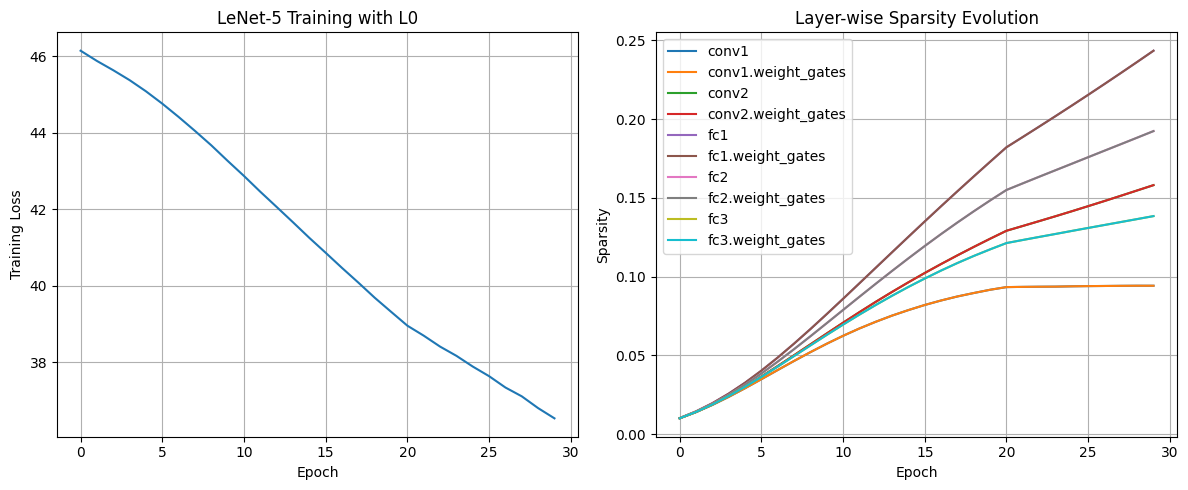


Final layer sparsities:
  conv1: 9.42% sparse (135/150 active)
  conv2: 15.80% sparse (2020/2400 active)
  fc1: 24.34% sparse (23244/30720 active)
  fc2: 19.23% sparse (8141/10080 active)
  fc3: 13.84% sparse (723/840 active)

Overall sparsity: 22.46%
Compression ratio: 1.3x


In [10]:
# Visualize layer-wise sparsity evolution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('LeNet-5 Training with L0')
plt.grid(True)

plt.subplot(1, 2, 2)
for name, sparsity_history in layer_sparsities.items():
    plt.plot(sparsity_history, label=name)
plt.xlabel('Epoch')
plt.ylabel('Sparsity')
plt.title('Layer-wise Sparsity Evolution')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Final sparsities
print("\nFinal layer sparsities:")
total_params = 0
active_params = 0
for name, module in lenet.named_modules():
    if hasattr(module, 'get_sparsity'):
        sparsity = module.get_sparsity()
        if hasattr(module, 'weight'):
            n_params = module.weight.numel()
            n_active = int(n_params * (1 - sparsity))
            total_params += n_params
            active_params += n_active
            print(f"  {name}: {sparsity:.2%} sparse ({n_active}/{n_params} active)")

print(f"\nOverall sparsity: {1 - active_params/total_params:.2%}")
print(f"Compression ratio: {total_params/active_params:.1f}x")

## 3. Feature Selection with L0

Using L0 gates for feature selection in tabular data.

In [11]:
# Create high-dimensional data with few informative features
n_samples = 500
n_features = 1000
n_informative = 20

# Generate classification data
X = torch.randn(n_samples, n_features)
true_weights = torch.zeros(n_features)
true_weights[:n_informative] = torch.randn(n_informative) * 3
logits = X @ true_weights
y = (torch.sigmoid(logits) > 0.5).long()

feature_names = [f"feature_{i}" for i in range(n_features)]
print(f"Dataset: {n_samples} samples, {n_features} features ({n_informative} informative)")

Dataset: 500 samples, 1000 features (20 informative)


In [12]:
# Feature selection with FeatureGate
feature_gate = FeatureGate(
    n_features=n_features,
    max_features=50,  # Select at most 50 features
    temperature=0.2
).to(device)

# Simple classifier on top of selected features
class FeatureSelectClassifier(nn.Module):
    def __init__(self, feature_gate):
        super().__init__()
        self.feature_gate = feature_gate
        self.classifier = nn.Linear(n_features, 1)
    
    def forward(self, x):
        # Apply feature gates
        gates = self.feature_gate.get_gates()
        x_gated = x * gates
        return self.classifier(x_gated).squeeze()

model = FeatureSelectClassifier(feature_gate).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    
    output = model(X.to(device))
    bce_loss = F.binary_cross_entropy_with_logits(output, y.float().to(device))
    l0_loss = feature_gate.get_penalty()
    total_loss = bce_loss + 0.001 * l0_loss
    
    total_loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 25 == 0:
        n_selected = len(feature_gate.get_active_indices())
        print(f"Epoch {epoch+1}: Loss={total_loss:.4f}, Selected features={n_selected}")

Epoch 25: Loss=0.7354, Selected features=42
Epoch 50: Loss=0.7167, Selected features=33
Epoch 75: Loss=0.7129, Selected features=46
Epoch 100: Loss=0.6408, Selected features=30



Top 30 selected features:
True informative features in top 30: 3/20


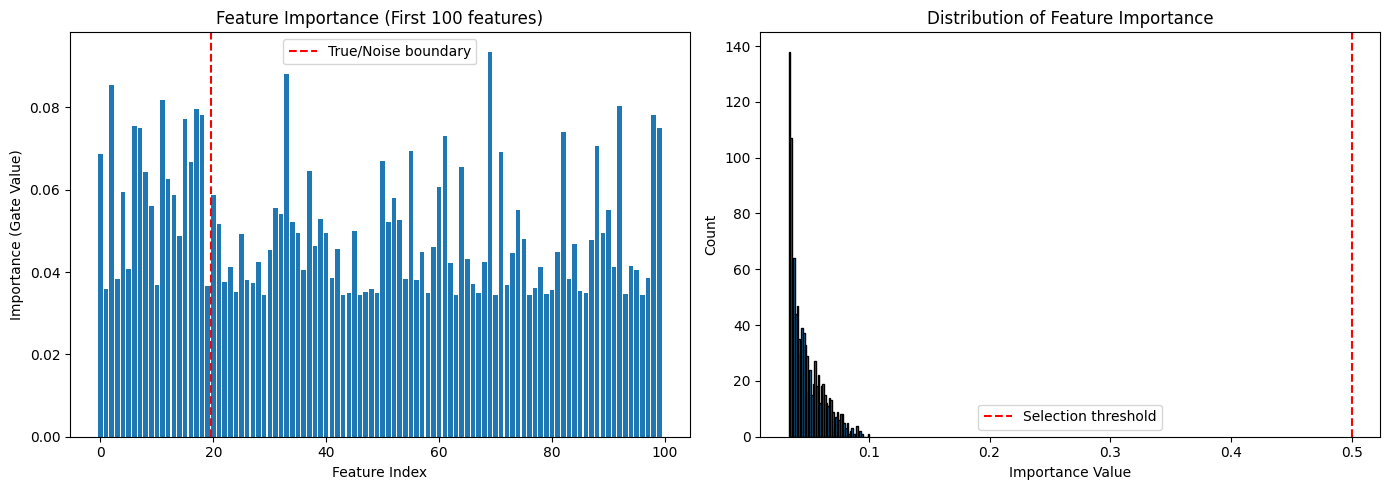

In [13]:
# Analyze selected features
model.eval()
importance = feature_gate.get_feature_importance()
top_30_indices = torch.topk(importance, 30).indices.cpu().numpy()

print(f"\nTop 30 selected features:")
print(f"True informative features in top 30: {sum(i < n_informative for i in top_30_indices)}/{n_informative}")

# Visualize feature importance
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.bar(range(100), importance[:100].cpu().numpy())
plt.axvline(x=n_informative-0.5, color='r', linestyle='--', label='True/Noise boundary')
plt.xlabel('Feature Index')
plt.ylabel('Importance (Gate Value)')
plt.title('Feature Importance (First 100 features)')
plt.legend()

plt.subplot(1, 2, 2)
# Show importance distribution
plt.hist(importance.cpu().numpy(), bins=50, edgecolor='black')
plt.xlabel('Importance Value')
plt.ylabel('Count')
plt.title('Distribution of Feature Importance')
plt.axvline(x=0.5, color='r', linestyle='--', label='Selection threshold')
plt.legend()

plt.tight_layout()
plt.show()

## 4. Comparing L0 with L1 Regularization

A direct comparison showing the difference between L0 and L1 sparsity.

In [14]:
# Create models for comparison
class L1Linear(nn.Module):
    """Standard linear layer with L1 regularization."""
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features, bias=False)
    
    def forward(self, x):
        return self.linear(x).squeeze()
    
    def get_l1_penalty(self):
        return self.linear.weight.abs().sum()
    
    def get_sparsity(self, threshold=1e-3):
        return (self.linear.weight.abs() < threshold).float().mean().item()

# Train both models on the same data
n_features = 100
X_train = torch.randn(500, n_features)
y_train = torch.randn(500)

# L0 model
l0_model = L0LinearRegression(n_features, init_sparsity=0.1).to(device)
l0_optimizer = optim.Adam(l0_model.parameters(), lr=0.01)

# L1 model
l1_model = L1Linear(n_features, 1).to(device)
l1_optimizer = optim.Adam(l1_model.parameters(), lr=0.01)

l0_sparsities = []
l1_sparsities = []

print("Training models...")
for epoch in range(100):
    # Train L0
    l0_optimizer.zero_grad()
    l0_pred = l0_model(X_train.to(device))
    l0_mse = F.mse_loss(l0_pred, y_train.to(device))
    l0_total = l0_mse + 0.01 * l0_model.get_l0_loss()
    l0_total.backward()
    l0_optimizer.step()
    l0_sparsities.append(l0_model.get_sparsity())
    
    # Train L1
    l1_optimizer.zero_grad()
    l1_pred = l1_model(X_train.to(device))
    l1_mse = F.mse_loss(l1_pred, y_train.to(device))
    l1_total = l1_mse + 0.01 * l1_model.get_l1_penalty()
    l1_total.backward()
    l1_optimizer.step()
    l1_sparsities.append(l1_model.get_sparsity())

print(f"\nFinal L0 sparsity: {l0_sparsities[-1]:.2%}")
print(f"Final L1 sparsity: {l1_sparsities[-1]:.2%}")

Training models...



Final L0 sparsity: 3.96%
Final L1 sparsity: 7.00%


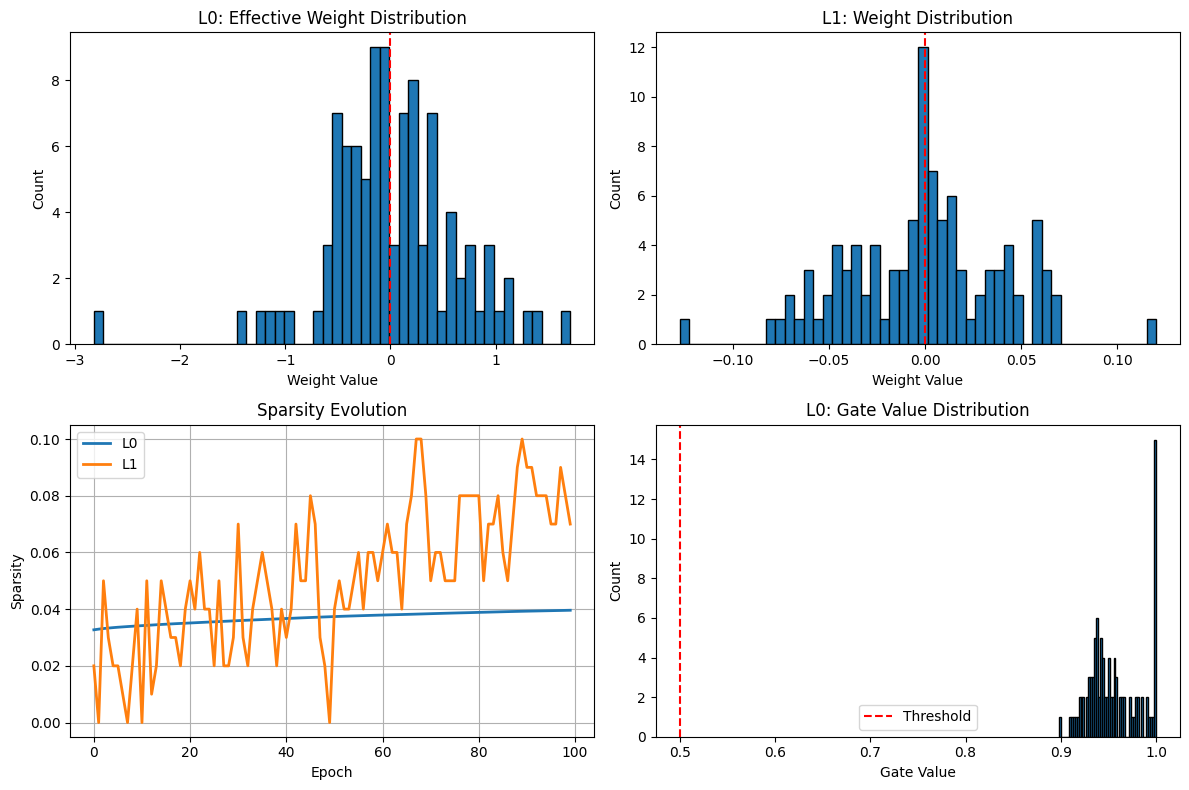


Exact zeros - L0: 0/100, L1: 7/100


In [15]:
# Compare weight distributions
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# L0 weights
l0_model.eval()
with torch.no_grad():
    l0_weights = l0_model.l0_linear.weight.squeeze().cpu().numpy()
    l0_gates = l0_model.l0_linear.weight_gates().squeeze().cpu().numpy()
    l0_effective = l0_weights * l0_gates

# L1 weights
l1_weights = l1_model.linear.weight.squeeze().detach().cpu().numpy()

# Plot weight distributions
axes[0, 0].hist(l0_effective, bins=50, edgecolor='black')
axes[0, 0].set_title('L0: Effective Weight Distribution')
axes[0, 0].set_xlabel('Weight Value')
axes[0, 0].set_ylabel('Count')
axes[0, 0].axvline(x=0, color='r', linestyle='--')

axes[0, 1].hist(l1_weights, bins=50, edgecolor='black')
axes[0, 1].set_title('L1: Weight Distribution')
axes[0, 1].set_xlabel('Weight Value')
axes[0, 1].set_ylabel('Count')
axes[0, 1].axvline(x=0, color='r', linestyle='--')

# Plot sparsity evolution
axes[1, 0].plot(l0_sparsities, label='L0', linewidth=2)
axes[1, 0].plot(l1_sparsities, label='L1', linewidth=2)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Sparsity')
axes[1, 0].set_title('Sparsity Evolution')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Plot gate distribution for L0
axes[1, 1].hist(l0_gates, bins=50, edgecolor='black')
axes[1, 1].set_title('L0: Gate Value Distribution')
axes[1, 1].set_xlabel('Gate Value')
axes[1, 1].set_ylabel('Count')
axes[1, 1].axvline(x=0.5, color='r', linestyle='--', label='Threshold')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Count exact zeros
l0_zeros = (l0_gates < 0.5).sum()
l1_zeros = (np.abs(l1_weights) < 1e-3).sum()
print(f"\nExact zeros - L0: {l0_zeros}/{n_features}, L1: {l1_zeros}/{n_features}")

## 5. Structured Sparsity with L0

Demonstrating channel-wise structured sparsity for CNNs.

In [16]:
# Create a CNN with structured sparsity
class StructuredSparseCNN(nn.Module):
    def __init__(self, structured=True):
        super().__init__()
        self.conv1 = L0Conv2d(3, 32, 3, structured=structured, init_sparsity=0.3)
        self.conv2 = L0Conv2d(32, 64, 3, structured=structured, init_sparsity=0.5)
        self.conv3 = L0Conv2d(64, 128, 3, structured=structured, init_sparsity=0.7)
        self.structured = structured
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        return x
    
    def get_active_channels(self):
        """Count active channels in each layer."""
        active = {}
        for name, module in self.named_modules():
            if isinstance(module, L0Conv2d):
                if self.structured and hasattr(module, 'channel_gates'):
                    gates = module.channel_gates.get_active_prob()
                    active[name] = (gates > 0.5).sum().item()
                else:
                    # For unstructured, estimate from weight gates
                    gates = module.weight_gates()
                    # Approximate active channels
                    channel_activity = gates.mean(dim=1)  # Average over input channels and kernel
                    active[name] = (channel_activity > 0.5).sum().item()
        return active

# Compare structured vs unstructured
structured_cnn = StructuredSparseCNN(structured=True).to(device)
unstructured_cnn = StructuredSparseCNN(structured=False).to(device)

print("Initial active channels:")
print(f"Structured: {structured_cnn.get_active_channels()}")
print(f"Unstructured: {unstructured_cnn.get_active_channels()}")

Initial active channels:
Structured: {'conv1': 32, 'conv2': 64, 'conv3': 128}
Unstructured: {'conv1': 32, 'conv2': 27, 'conv3': 0}


Structured Sparsity Pattern:


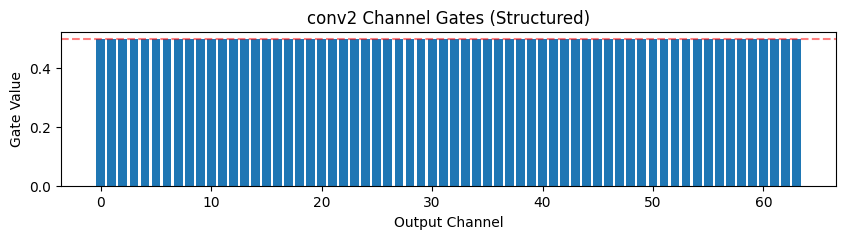


Unstructured Sparsity Pattern:


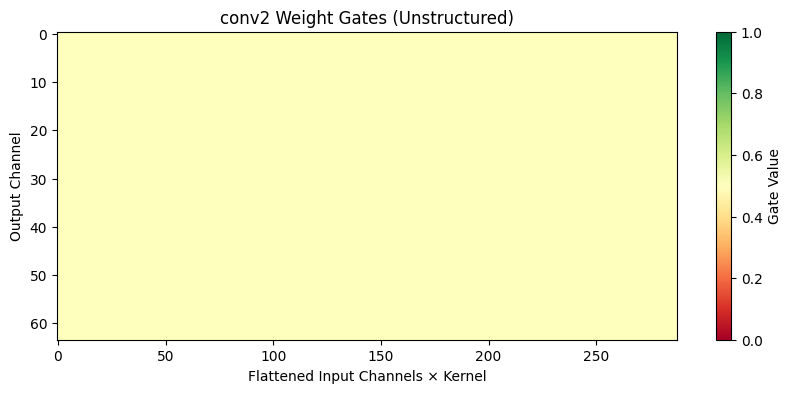

In [17]:
# Visualize structured vs unstructured sparsity patterns
def visualize_conv_sparsity(model, layer_name='conv2'):
    """Visualize sparsity pattern in a conv layer."""
    for name, module in model.named_modules():
        if name == layer_name and isinstance(module, L0Conv2d):
            module.eval()
            with torch.no_grad():
                if model.structured and hasattr(module, 'channel_gates'):
                    # Structured: show channel gates
                    gates = module.channel_gates().cpu().numpy()
                    plt.figure(figsize=(10, 2))
                    plt.bar(range(len(gates)), gates)
                    plt.xlabel('Output Channel')
                    plt.ylabel('Gate Value')
                    plt.title(f'{layer_name} Channel Gates (Structured)')
                    plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.5)
                else:
                    # Unstructured: show weight gate heatmap
                    gates = module.weight_gates()
                    # Reshape to (out_channels, -1) for visualization
                    gates_2d = gates.view(gates.shape[0], -1).cpu().numpy()
                    
                    plt.figure(figsize=(10, 4))
                    plt.imshow(gates_2d, aspect='auto', cmap='RdYlGn', vmin=0, vmax=1)
                    plt.colorbar(label='Gate Value')
                    plt.xlabel('Flattened Input Channels × Kernel')
                    plt.ylabel('Output Channel')
                    plt.title(f'{layer_name} Weight Gates (Unstructured)')
                plt.show()
                break

print("Structured Sparsity Pattern:")
visualize_conv_sparsity(structured_cnn, 'conv2')

print("\nUnstructured Sparsity Pattern:")
visualize_conv_sparsity(unstructured_cnn, 'conv2')

## 6. Temperature Annealing Effects

Demonstrating the importance of temperature scheduling.

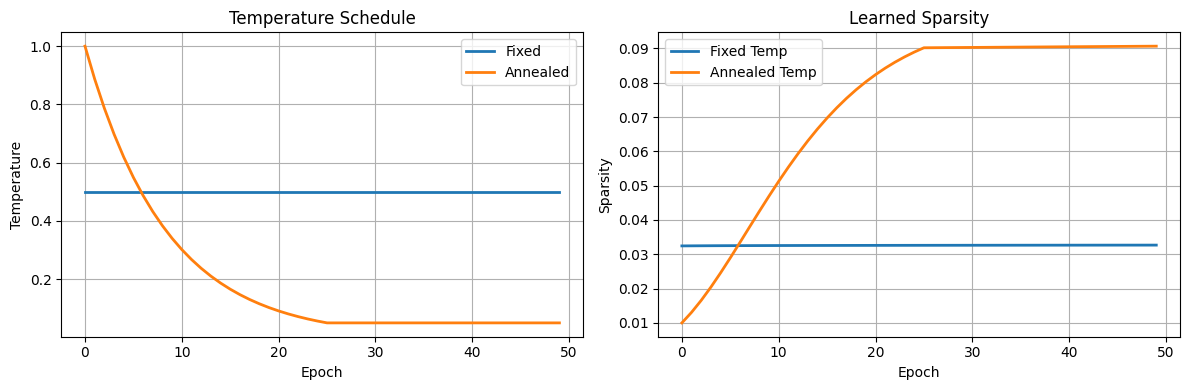

Final sparsity - Fixed: 3.27%, Annealed: 9.07%


In [18]:
# Compare fixed vs annealed temperature
def train_with_temperature_strategy(strategy='fixed', n_epochs=50):
    model = SparseMLP(input_dim=100, hidden_dim=50, output_dim=10, 
                      init_sparsity=0.1, temperature=0.5).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    if strategy == 'annealed':
        temp_scheduler = TemperatureScheduler(1.0, 0.05, n_epochs//2)
    
    X = torch.randn(200, 100).to(device)
    y = torch.randint(0, 10, (200,)).to(device)
    
    temps = []
    sparsities = []
    
    for epoch in range(n_epochs):
        if strategy == 'annealed':
            temp = temp_scheduler.get_temperature(epoch)
            update_temperatures(model, temp)
        else:
            temp = 0.5  # Fixed
        
        model.train()
        optimizer.zero_grad()
        output = model(X)
        loss = F.cross_entropy(output, y) + 1e-3 * model.get_l0_loss()
        loss.backward()
        optimizer.step()
        
        temps.append(temp)
        stats = model.get_sparsity_stats()
        avg_sparsity = np.mean([s['sparsity'] for s in stats.values()])
        sparsities.append(avg_sparsity)
    
    return temps, sparsities

# Run experiments
fixed_temps, fixed_sparsities = train_with_temperature_strategy('fixed')
annealed_temps, annealed_sparsities = train_with_temperature_strategy('annealed')

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(fixed_temps, label='Fixed', linewidth=2)
ax1.plot(annealed_temps, label='Annealed', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Temperature')
ax1.set_title('Temperature Schedule')
ax1.legend()
ax1.grid(True)

ax2.plot(fixed_sparsities, label='Fixed Temp', linewidth=2)
ax2.plot(annealed_sparsities, label='Annealed Temp', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Sparsity')
ax2.set_title('Learned Sparsity')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"Final sparsity - Fixed: {fixed_sparsities[-1]:.2%}, Annealed: {annealed_sparsities[-1]:.2%}")

## Summary

This notebook demonstrated:

1. **Basic L0 regularization** learns to identify informative features
2. **LeNet-5 with L0** achieves high sparsity while maintaining accuracy
3. **Feature selection** with L0 gates for high-dimensional data
4. **L0 vs L1 comparison** shows L0 produces exact zeros while L1 only shrinks weights
5. **Structured sparsity** prunes entire channels/filters for hardware efficiency  
6. **Temperature annealing** improves convergence and final sparsity

Key takeaways:
- L0 regularization provides differentiable, learnable sparsity
- Temperature scheduling is important for good results
- Structured sparsity is more hardware-friendly than unstructured
- L0 produces true sparsity (exact zeros) unlike L1/L2

For production use, train on real datasets (MNIST, CIFAR-10, etc.) for meaningful results.